In [12]:
from causallib.datasets import load_card_krueger
from causallib.estimation import Matching,MatchingTransformer,PropensityMatching,IPW,StratifiedStandardization,MarginalOutcomeEstimator

all_covariates = ['CHAIN','CO_OWNED','NCALLS', 'EMPFT', 'EMPPT', 'NMGRS', 'WAGE_ST', 'INCTIME', 'FIRSTINC', 
                  'BONUS', 'PCTAFF', 'MEALS', 'OPEN', 'HRSOPEN', 'PSODA', 'PFRY', 'PENTREE', 'NREGS', 'NREGS11',
                  "BK","KFC","ROYS","WENDYS"]

all_except_p = [i for i in all_covariates if not i in ["PSODA","PFRY","PENTREE"]]
data_all = load_card_krueger(select_covariates=all_covariates)
data = load_card_krueger()
data_all_except_p = load_card_krueger(select_covariates=all_except_p)
x,a,y = data.X,data.a,data.y
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
import pandas as pd
import numpy as np
from causallib.utils.stat_utils import calc_weighted_standardized_mean_differences
from causallib.evaluation.weight_evaluator import calculate_covariate_balance
from causallib.evaluation import PropensityEvaluator,WeightEvaluator
from sklearn.linear_model import LassoCV,Lasso,LinearRegression
import statsmodels.api as sm
from causallib.evaluation.weight_evaluator import calculate_covariate_balance
from sklearn import metrics as skmetrics
from matplotlib import pyplot as plt
learner = lambda : LogisticRegression(solver="liblinear",class_weight="balanced",max_iter=5000)
#learner = lambda : MLPClassifier(hidden_layer_sizes=(16,32,16,8),max_iter=5000)


After loading the data, we begin by checking the association between treatment and outcome, without any causal inference.

In [23]:
naive_ate = y[a==1].mean() - y[a==0].mean()
print(f"NJ fast food restaurants had a change of {naive_ate:.5f} employees compared to PA fast food restaurants.")

NJ fast food restaurants had a change of -0.21974 employees compared to PA fast food restaurants.


Based on this, we would conclude that the increase in minimum wage in fact decreased employment levels in fast food restaurants. However, this inference would only be justified if the restaurants in NJ and PA were otherwise equivalent. Let us check that now:

In [24]:
calculate_covariate_balance(x,a,w=a*0+1)["unweighted"].sort_values()

covariate
ROYS       0.001462
BK         0.015325
WAGE_ST    0.038154
INCTIME    0.080553
WENDYS     0.127842
KFC        0.142869
EMPTOT     0.195605
Name: unweighted, dtype: float64

In [26]:
x.groupby(a).mean()

,EMPTOT,WAGE_ST,INCTIME,BK,KFC,ROYS,WENDYS
STATE,,,,,,,
0,20.172794,4.623382,19.051471,0.426471,0.132353,0.250000,0.191176
1,17.273297,4.604803,17.691756,0.415771,0.207885,0.250896,0.125448


Here we see that the untreated state (PA) had quite a bit higher employment levels `EMPTOT` than the treated state (NJ) prior to the intervention. Could it be that the measured decline in employment in NJ is in fact explained by the prior lower number of employees per branch? In order to answer this question we need to estimate the difference in counterfactual outcomes:
$$ATE = E[Y^{a=1}] - E[Y^{a=0}]$$
The fundamental problem of causal inference is that for each sample we need _both_ treated and untreated outcomes, but in reality no sample was both treated and untreated. Causal inference has many ways to estimate this quantity and `causallib` implements several of them.

In [54]:
from causallib.estimation import (
    DoublyRobustIpFeature,
    DoublyRobustJoffe,
    DoublyRobustVanilla,
    IPW,
    Standardization,
    StratifiedStandardization,
    MarginalOutcomeEstimator,
    Matching,
    PropensityMatching,
    MatchingTransformer,
    MatchingIndividualOutcomeEstimator,
)
from causallib.datasets import load_nhefs, load_card_krueger, load_lalonde, load_acic16
from sklearn.linear_model import LogisticRegression, LinearRegression
import pandas as pd


def makeipw(): return IPW(learner=LogisticRegression(solver="liblinear"))
def makestd(): return StratifiedStandardization(learner=LinearRegression())


all_estimators = [
    MarginalOutcomeEstimator(learner=LinearRegression()),
    Matching(with_replacement=False),
    PropensityMatching(learner=LogisticRegression(
        solver="liblinear"), caliper=0.1),
    MatchingIndividualOutcomeEstimator(),
    IPW(learner=LogisticRegression(solver="liblinear")),
    Standardization(learner=LinearRegression()),
    StratifiedStandardization(learner=LinearRegression()),
    DoublyRobustIpFeature(makestd(), makeipw()),
    DoublyRobustJoffe(makestd(), makeipw()),
    DoublyRobustVanilla(makestd(), makeipw()),
]


def get_all_estimates(x, a, y):
    estimates = {}
    for estimator in all_estimators:
        try:
            estimator.fit(x, a, y)
        except:
            estimator.fit(x, a)
        estimator_name = estimator.__class__.__name__
        estimates[estimator_name] = estimator.estimate_population_outcome(
            x, a, y)
    estimates_df = pd.concat(estimates, axis=1).T
    return estimates_df

In [55]:
all_estimates = get_all_estimates(x,a,y)
all_estimates.assign(ATE=all_estimates[1] - all_estimates[0])

,0,1,ATE
MarginalOutcomeEstimator,17.544118,17.324373,-0.219745
Matching,17.544118,18.897059,1.352941
PropensityMatching,16.433526,17.602601,1.169075
MatchingIndividualOutcomeEstimator,16.721902,17.394813,0.672911
IPW,16.506427,17.653360,1.146933
Standardization,16.285505,17.631131,1.345626
StratifiedStandardization,16.664511,17.672040,1.007530
DoublyRobustIpFeature,16.781815,17.634654,0.852839
DoublyRobustJoffe,16.623071,17.673107,1.050036
DoublyRobustVanilla,16.617908,17.674260,1.056352


([<matplotlib.axis.XTick at 0x7efff04337c0>,
 [Text(0, 0, 'PA'), Text(1, 0, 'NJ')])

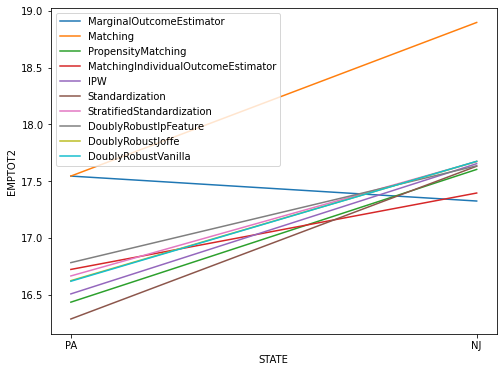

In [56]:
f,ax=plt.subplots(figsize=(8,6))
all_estimates.T.plot(ax=ax)
plt.ylabel(y.name)
plt.xlabel(a.name)
plt.xticks([0,1],["PA", "NJ"])

All of the causal inference methods work by estimating what would have happened if the same sample with the same covariates received a treatment other than the one it actually received. The `MarginalOutcomeEstimator` simply implements the naive estimate shown above. Each of the causal methods shifted the estimate of `EMPTOT2` down for PA and, to a lesser extent, up for NJ. 

In [57]:
xm,am,ym=MatchingTransformer(with_replacement=False).fit_transform(x,a,y)
print(f"Transforming data from {x.shape[0]} samples to {xm.shape[0]} samples by matching without replacement.")
all_estimates_matched = get_all_estimates(xm,am,ym)
all_estimates_matched.assign(ATE=all_estimates_matched[1] - all_estimates_matched[0])

Transforming data from 347 samples to 136 samples by matching without replacement.


,0,1,ATE
MarginalOutcomeEstimator,17.544118,18.897059,1.352941
Matching,17.544118,18.897059,1.352941
PropensityMatching,17.318015,18.248162,0.930147
MatchingIndividualOutcomeEstimator,17.262868,18.707721,1.444853
IPW,17.406091,18.996176,1.590085
Standardization,17.409981,19.031195,1.621214
StratifiedStandardization,17.417244,19.044111,1.626867
DoublyRobustIpFeature,17.512552,18.666084,1.153531
DoublyRobustJoffe,17.414967,19.039146,1.624179
DoublyRobustVanilla,17.414449,19.039553,1.625104


([<matplotlib.axis.XTick at 0x7efff033ed30>,
 [Text(0, 0, 'PA'), Text(1, 0, 'NJ')])

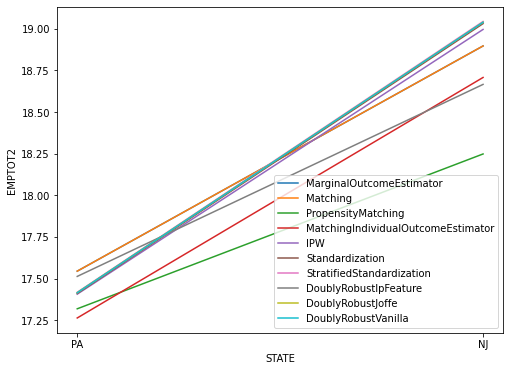

In [58]:
f,ax=plt.subplots(figsize=(8,6))
all_estimates_matched.T.plot(ax=ax)
plt.ylabel(y.name)
plt.xlabel(a.name)
plt.xticks([0,1],["PA", "NJ"])

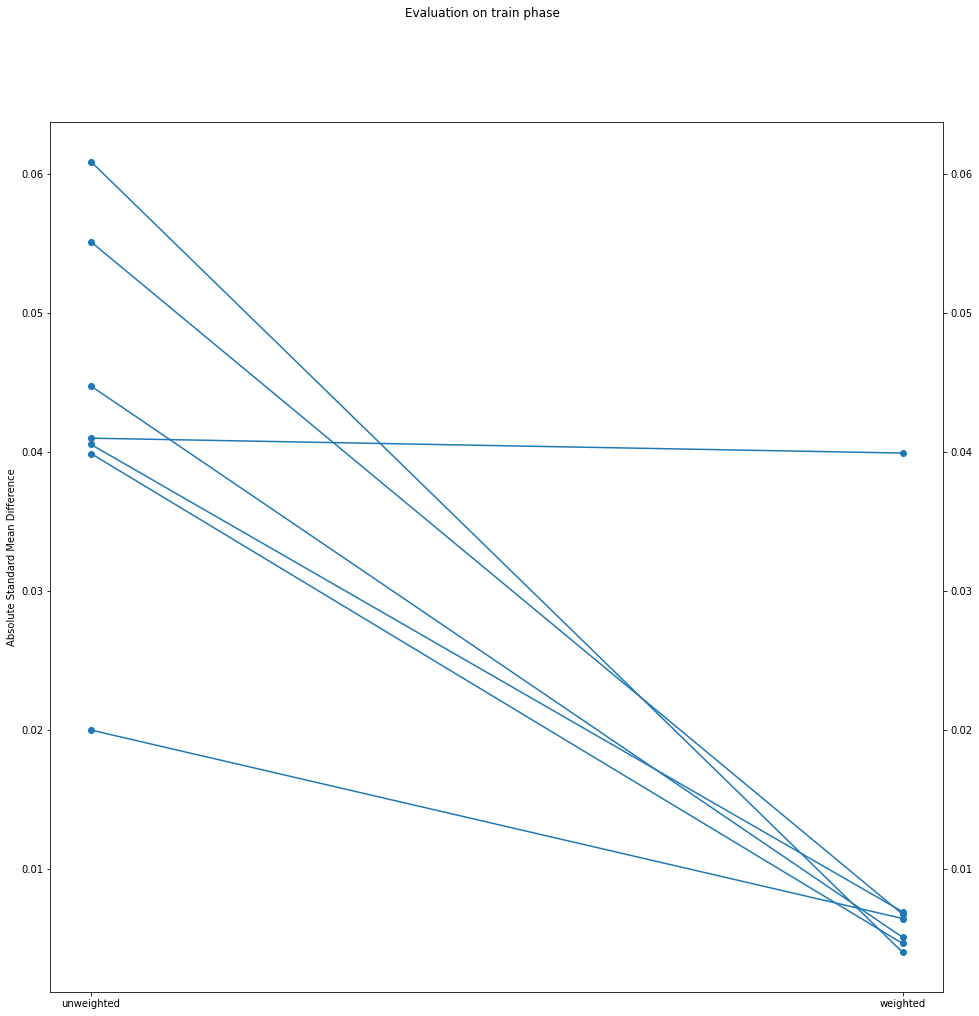

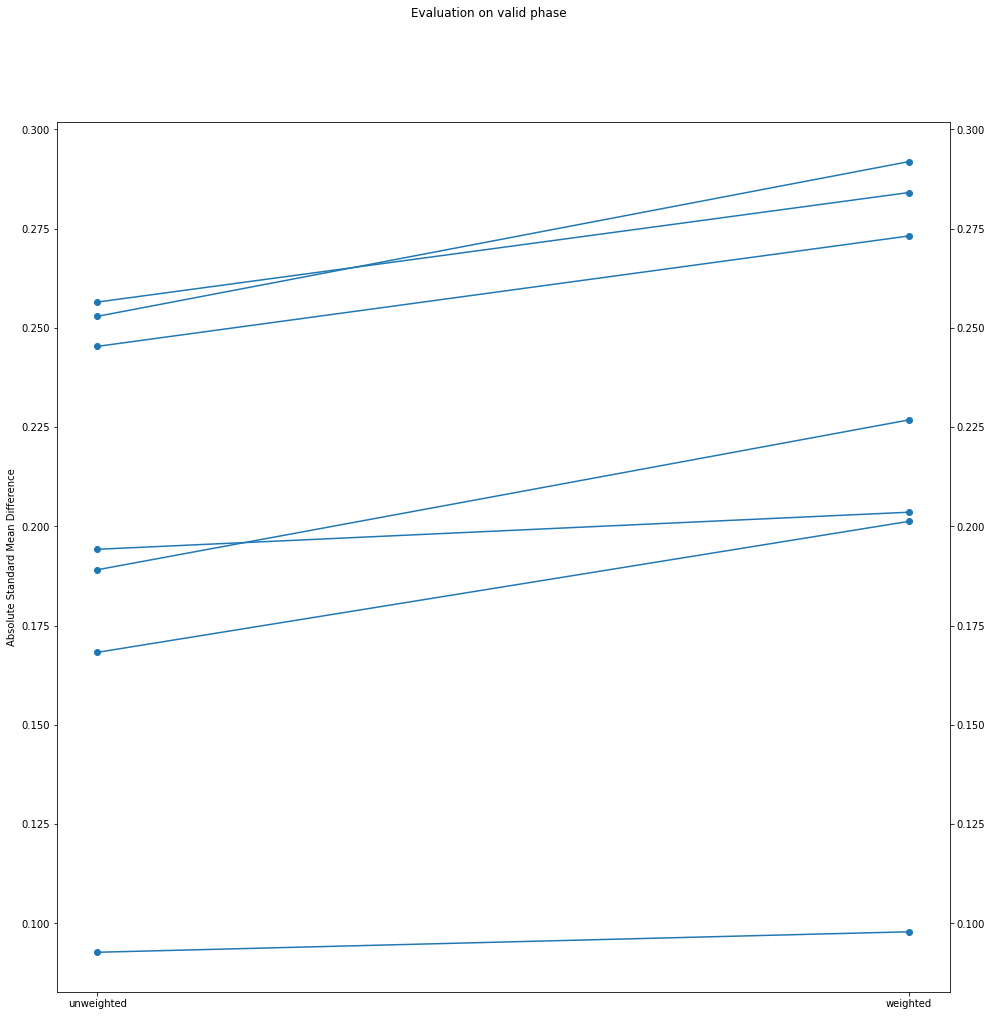

In [62]:
plots=["covariate_balance_slope"]

metrics = {"roc_auc": skmetrics.roc_auc_score,
           "avg_precision": skmetrics.average_precision_score,}
ipw = IPW(learner=learner())
evaluator = PropensityEvaluator(ipw)
results = evaluator.evaluate_cv(xm,am,ym, 
                                plots=plots, metrics_to_evaluate=metrics)

In [60]:
m = PropensityMatching(learner=learner())
m.propensity_transform.include_covariates = True
m.caliper = 0.01
m.fit(x,a,y)
xm,am,ym = m.transform(x,a,y)

AttributeError: 'PropensityMatching' object has no attribute 'transform'

In [61]:
match_df = pd.concat({0:m.match_df_.loc[0][a==1],1:m.match_df_.loc[1][a==0]})
first = lambda x: x[0] if x else None
match_df.loc[0].distances.apply(first).hist(density=True,label=0,histtype="stepfilled",alpha=0.7)
ax=match_df.loc[1].distances.apply(first).hist(density=True,label=1,histtype="stepfilled",alpha=0.7)
ax.legend()

AttributeError: 'PropensityMatching' object has no attribute 'match_df_'

In [ ]:
ipw = IPW(learner=learner())
ipw.fit(xm,am,)
ipw.estimate_population_outcome(xm,am,ym)

In [ ]:
ipw = IPW(learner=learner())
ipw.fit(x,a,)
ipw.estimate_population_outcome(x,a,y)

In [ ]:
w = ipw.compute_weights(xm,am)

In [ ]:
calculate_covariate_balance(xm,am,w)

In [ ]:
from sklearn import metrics as skmetrics
plots=["roc_curve", "pr_curve", "weight_distribution", 
       "calibration", "covariate_balance_love", "covariate_balance_slope"]

metrics = {"roc_auc": skmetrics.roc_auc_score,
           "avg_precision": skmetrics.average_precision_score,}
ipw = IPW(learner=learner())
evaluator = PropensityEvaluator(ipw)
results = evaluator.evaluate_cv(x,a,y, 
                                plots=plots, metrics_to_evaluate=metrics)

In [ ]:
from sklearn.linear_model import LinearRegression
from causallib.estimation import DoublyRobustJoffe,DoublyRobustIpFeature,DoublyRobustVanilla
ss = StratifiedStandardization(learner=LinearRegression())
ss.fit(x,a,y)
ss.estimate_population_outcome(x,a,)
drip = DoublyRobustIpFeature(ss,ipw)
drip.fit(x,a,y)
drip.estimate_population_outcome(x,a)

In [ ]:
a.unique()

In [ ]:
lv_a = Lasso(alpha=0.2)
lv_a.fit(x,a)
lv_y = Lasso(alpha=0.2)
lv_y.fit(x,y)
lvdf = pd.DataFrame(data = [lv_a.coef_,lv_y.coef_],index=["a","y"],columns=x.columns).T
print(lvdf[(abs(lvdf.a)>0) | (abs(lvdf.y)>0)])
lasso_covariates = list(lvdf[(abs(lvdf.a)>0) | (abs(lvdf.y)>0)].index)
data_lasso = load_card_krueger_data(select_covariates=lasso_covariates)

x,a,y = data_lasso.x,data_lasso.a,data_lasso.y

What parameters are actually associated with outcome and thus relevant as possible confounders? One test is if 0 is not in the 95% confidence interval.

In [ ]:
y_assoc = sm.OLS(data_all.y,sm.add_constant(data_all.x)).fit()
a_assoc = sm.OLS(data_all.a,sm.add_constant(data_all.x)).fit()

pvalues = pd.concat({"treatment":y_assoc.pvalues,"outcome":a_assoc.pvalues},axis=1).drop(index="const")

associated_variables = pvalues[(pvalues.treatment < 0.1 ) & (pvalues.outcome < 0.1)].index
pvalues[(pvalues.treatment < 0.1 ) & (pvalues.outcome < 0.1)]

In [ ]:
data_associated = load_card_krueger_data(select_covariates=associated_variables)
data.descriptors.loc[associated_variables]

In [ ]:
x,a,y=data_associated.x,data_associated.a,data_associated.y
mt = MatchingTransformer(with_replacement=False)
xm,am,ym=mt.fit_transform(x,a,y)
